In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Evaluate model predictions
### Select best predicted squad and compare gained points with average points from specific gameweek

In [2]:
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from src.data.data_loader import load_average_pts
from src.features.data_engineering import preprocess_seasons_data
from src.features.data_engineering import reverse_processing

from src.modeling.train_model import train_mlp_model
from src.modeling.predictions import merge_reversed_data_with_predictions
from src.modeling.evaluate_squad import squad_selection_without_constraints
from src.modeling.evaluate_squad import get_average_pts
from src.modeling.evaluate_squad import evaluate_selected_squad_without_constraints

In [3]:
average_pts = load_average_pts()

In [4]:
average_pts.head()

,GW,AVG_PTS_2016/17,AVG_PTS_2018/19,AVG_PTS_2021/22
0,1,44,53,69
1,2,56,59,56
2,3,40,48,54
3,4,41,43,57
4,5,47,46,55


## Load specific test gameweek data
**NOTE:** To properly evaluate model predictions comparing it with average points from specific gameweek, remember to leave performance sample of every player from specific gameweek in test dataset

In [5]:
test_subset = (['2016-17', [35,36,37]], ['2021-22', [27,28,29]])

(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(random_split=False, test_subset=test_subset)

In [6]:
# preview unique values in 'season' and 'GW' columns from x_test_target
print(x_test_target.season.unique())
print(x_test_target.GW.unique())

['2016-17' '2021-22']
[35 36 37 27 28 29]


## Train MLP and XGBoost models on specific subset and save them

In [7]:
# model = tf.keras.models.Sequential()
#
# model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
# model.add(tf.keras.layers.Dense(units=126, activation='relu'))
# model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# model.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [8]:
# model_mlp = train_mlp_model(model, x_train, y_train)

Epoch 1/30
6246/6246 [==============================] - 8s 1ms/step - loss: 4.7243 - val_loss: 4.4329
Epoch 2/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.6402 - val_loss: 4.3777
Epoch 3/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.6261 - val_loss: 4.3645
Epoch 4/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.6170 - val_loss: 4.3387
Epoch 5/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.6004 - val_loss: 4.3444
Epoch 6/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.5943 - val_loss: 4.3263
Epoch 7/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.5864 - val_loss: 4.3617
Epoch 8/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.5842 - val_loss: 4.3707
Epoch 9/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.5818 - val_loss: 4.3984
Epoch 10/30
6246/6246 [==============================] - 7s 1ms/step - loss: 4.572

In [9]:
# model_xgb = xgb.XGBRegressor()
# model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [10]:
import os
root_dir = os.path.dirname(os.path.abspath(''))

In [11]:
# model_mlp.save(root_dir + '\\models\\baseline\\mlp_model_06-07-22.h5')
# model_xgb.save_model(root_dir + '\\models\\baseline\\xgb_model_06-07-22.json')

## Make predictions on specific test subset using MLP and XGBoost models

In [14]:
model_mlp = tf.keras.models.load_model(root_dir + '\\models\\baseline\\mlp_model_06-07-22.h5')
model_xgb = xgb.XGBRegressor()
model_xgb.load_model(root_dir + '\\models\\baseline\\xgb_model_06-07-22.json')

In [15]:
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)

In [16]:
predictions_merged_mlp = merge_reversed_data_with_predictions(model_mlp, x_test, y_test, x_test_reversed)
predictions_merged_xgb = merge_reversed_data_with_predictions(model_xgb, x_test, y_test, x_test_reversed)

### Evaluate MLP model predictions without constraints for gameweek 27 in 2021-22 season
At this moment, I do not take price constraints into account.

In [17]:
# get data from predictions_merged only for 2021-22 season and gameweek 27
predictions_merged_27 = predictions_merged_mlp[(predictions_merged_mlp.season == '2021-22') & (predictions_merged_mlp.GW == 27)]
# sort predictions_merged_27 by predicted points in descending order
predictions_merged_27 = predictions_merged_27.sort_values(by='predicted_total_points_next_gameweek', ascending=False)

In [18]:
# get first row from predictions_merged_27 and double 'total_points_next_gameweek' value, because this player would be chosen as a capitan
predictions_merged_27.iloc[0, predictions_merged_27.columns.get_loc('total_points_next_gameweek')] *= 2

In [19]:
# get goalkeepers from predictions_merged_27 (with 1 in 'position_GK' column)
# df_gk_27 = predictions_merged_27[predictions_merged_27.position_GK == 1]
# df_def_27 = predictions_merged_27[predictions_merged_27.position_DEF == 1]
# df_mid_27 = predictions_merged_27[predictions_merged_27.position_MID == 1]
# df_fwd_27 = predictions_merged_27[predictions_merged_27.position_FWD == 1]

# separate players by position
df_top_11_27 = pd.DataFrame()
positions = ['position_GK', 'position_DEF', 'position_MID', 'position_FWD']
formation = [1, 3, 5, 2]
for i, position in enumerate(positions):
    # get players with the given position
    players = predictions_merged_27[predictions_merged_27[position] == 1].head(formation[i])
    # add players to df_top_11 dataframe
    df_top_11_27 = pd.concat((df_top_11_27, players), ignore_index=True)

In [27]:
# get 'name', 'total_points_next_gameweek', 'transfers_balance', 'value' columns from df_top_11
df_top_11_27[['name', 'total_points_next_gameweek', 'GW', 'value']]

,name,total_points_next_gameweek,GW,value
0,Nick Pope,2.0,27,54.0
1,JoÃ£o Pedro Cavaco Cancelo,2.0,27,71.0
2,RÃºben Santos Gato Alves Dias,0.0,27,63.0
3,Ben Mee,1.0,27,48.0
4,Kevin De Bruyne,18.0,27,119.0
5,Heung-Min Son,7.0,27,108.0
6,Bruno Miguel Borges Fernandes,2.0,27,117.0
7,Bernardo Mota Veiga de Carvalho e Silva,6.0,27,73.0
8,Raheem Sterling,0.0,27,107.0
9,Jamie Vardy,4.0,27,103.0


In [22]:
df_top_11_27.total_points_next_gameweek.sum()

55.0

In [23]:
# get number of avg points from avg_pts where season is 2021-22 and gameweek is 27

average_pts.loc[average_pts['GW'] == 27, ['AVG_PTS_2021/22']].values[0][0]

40

### Evaluate MLP model for whole test_subset

In [24]:
test_subset = (['2016-17', [35,36,37]], ['2021-22', [27,28,29]])

In [30]:
results = []
gameweeks = []
for season in test_subset:
    for gameweek in season[1]:
        results.append(squad_selection_without_constraints(predictions_merged_mlp, season[0], gameweek))
        gameweeks.append((season[0], gameweek + 1))

selected_squad_points_mlp = []
for result in results:
    selected_squad_points_mlp.append(result[1])

real_player_average_points = []
for gameweek in gameweeks:
    real_player_average_points.append(get_average_pts(gameweek[0], gameweek[1]))

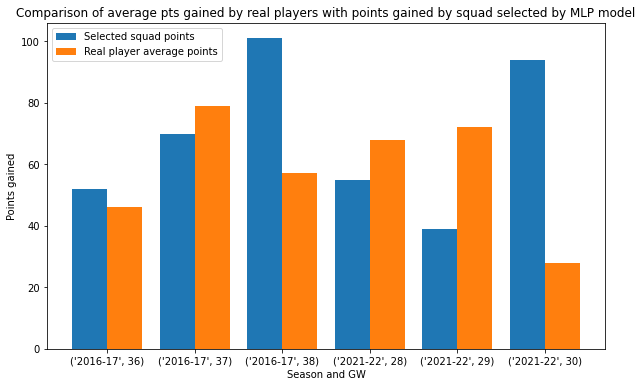

In [31]:
plt.figure(figsize=(10,6))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_mlp, 0.4, label = 'Selected squad points')
plt.bar(X_axis + 0.2, real_player_average_points, 0.4, label = 'Real player average points')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of average pts gained by real players with points gained by squad selected by MLP model")
plt.legend()
plt.show()

In [32]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp))
print('Sum of points gained by real players:', sum(real_player_average_points))
print('Difference:', sum(selected_squad_points_mlp) - sum(real_player_average_points), 'pts')

Sum of points gained by selected squad: 411.0
Sum of points gained by real players: 350
Difference: 61.0 pts


### Evaluate XGB model for whole test_subset

In [36]:
results = []
gameweeks = []
for season in test_subset:
    for gameweek in season[1]:
        results.append(squad_selection_without_constraints(predictions_merged_xgb, season[0], gameweek))
        gameweeks.append((season[0], gameweek + 1))

selected_squad_points_xgb = []
for result in results:
    selected_squad_points_xgb.append(result[1])

print(selected_squad_points_xgb)

[50.0, 59.0, 81.0, 37.0, 61.0, 66.0]


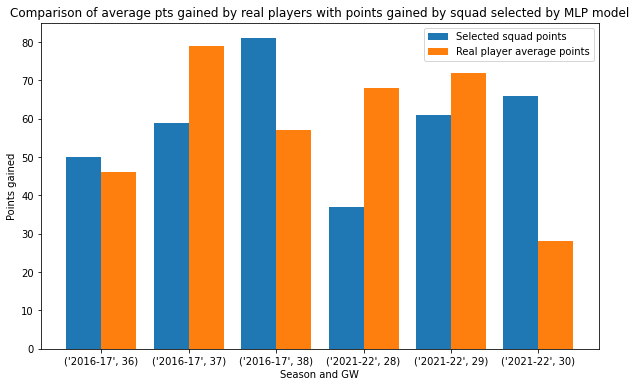

In [37]:
plt.figure(figsize=(10,6))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_xgb, 0.4, label = 'Selected squad points')
plt.bar(X_axis + 0.2, real_player_average_points, 0.4, label = 'Real player average points')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of average pts gained by real players with points gained by squad selected by MLP model")
plt.legend()
plt.show()

In [38]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb))
print('Sum of points gained by real players:', sum(real_player_average_points))
print('Difference:', sum(selected_squad_points_xgb) - sum(real_player_average_points), 'pts')

Sum of points gained by selected squad: 354.0
Sum of points gained by real players: 350
Difference: 4.0 pts


### Conclusion
These results look promising. Squad selected by AI MLP model seems to gain more points than real players on average. With this test_subset, XGBoost model gained significantly lower amount of points than MLP model, but still more than real average FPL player. But we need to notice that it just simple initial comparison. Predictions are taken from simple baseline model without any price constraints and we tested it only on 6 gameweeks. So it is not very accurate at this moment, but it's a great step towards main goal of this project, which is AI model that can achieve better results than average real player during the whole FPL season.

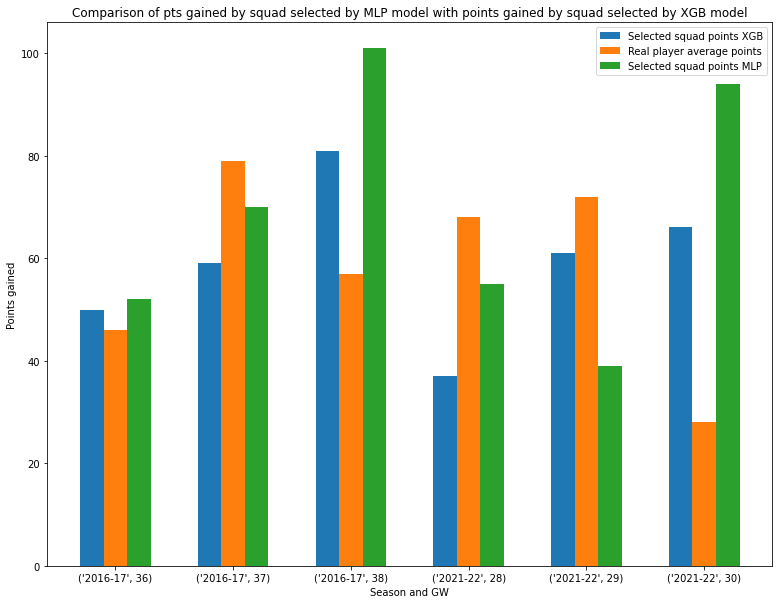

In [39]:
plt.figure(figsize=(13,10))

X_axis = np.arange(len(gameweeks))

plt.bar(X_axis - 0.2, selected_squad_points_xgb, 0.2, label = 'Selected squad points XGB')
plt.bar(X_axis, real_player_average_points, 0.2, label = 'Real player average points')
plt.bar(X_axis + 0.2, selected_squad_points_mlp, 0.2, label = 'Selected squad points MLP')

plt.xticks(X_axis, gameweeks)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model")
plt.legend()
plt.show()

In [29]:
# run evaluation on test_subset and log results to mlflow
#evaluate_selected_squad_without_constraints(predictions_merged_mlp, test_subset, 'mlp_model_06-07-22')
#evaluate_selected_squad_without_constraints(predictions_merged_xgb, test_subset, 'xgb_model_06-07-22')

## Evaluate models on bigger test_subset

In [5]:
test_subset_XL = (['2016-17', [4, 8, 9, 14, 18, 20, 21, 26, 32]], ['2018-19', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], ['2021-22', [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(random_split=False, test_subset=test_subset_XL)

# Train MLP and XGBoost models on specific subset
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=126, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model_mlp = train_mlp_model(model, x_train, y_train, verbose=0)

model_xgb = xgb.XGBRegressor()
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [6]:
# Make predictions on specific test subset using MLP and XGBoost models
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)
predictions_merged_mlp = merge_reversed_data_with_predictions(model_mlp, x_test, y_test, x_test_reversed)
predictions_merged_xgb = merge_reversed_data_with_predictions(model_xgb, x_test, y_test, x_test_reversed)

# Get squad and evaluate it for both models
results_mlp, selected_squad_points_mlp, real_player_average_points_mlp, season_gameweeks_mlp = evaluate_selected_squad_without_constraints(predictions_merged_mlp, test_subset_XL, 'mlp_model-no_constraints_test_subset_XL')
results_xgb, selected_squad_points_xgb, real_player_average_points_xgb, season_gameweeks_xgb = evaluate_selected_squad_without_constraints(predictions_merged_xgb, test_subset_XL, 'xgb_model-no_constraints_test_subset_XL')

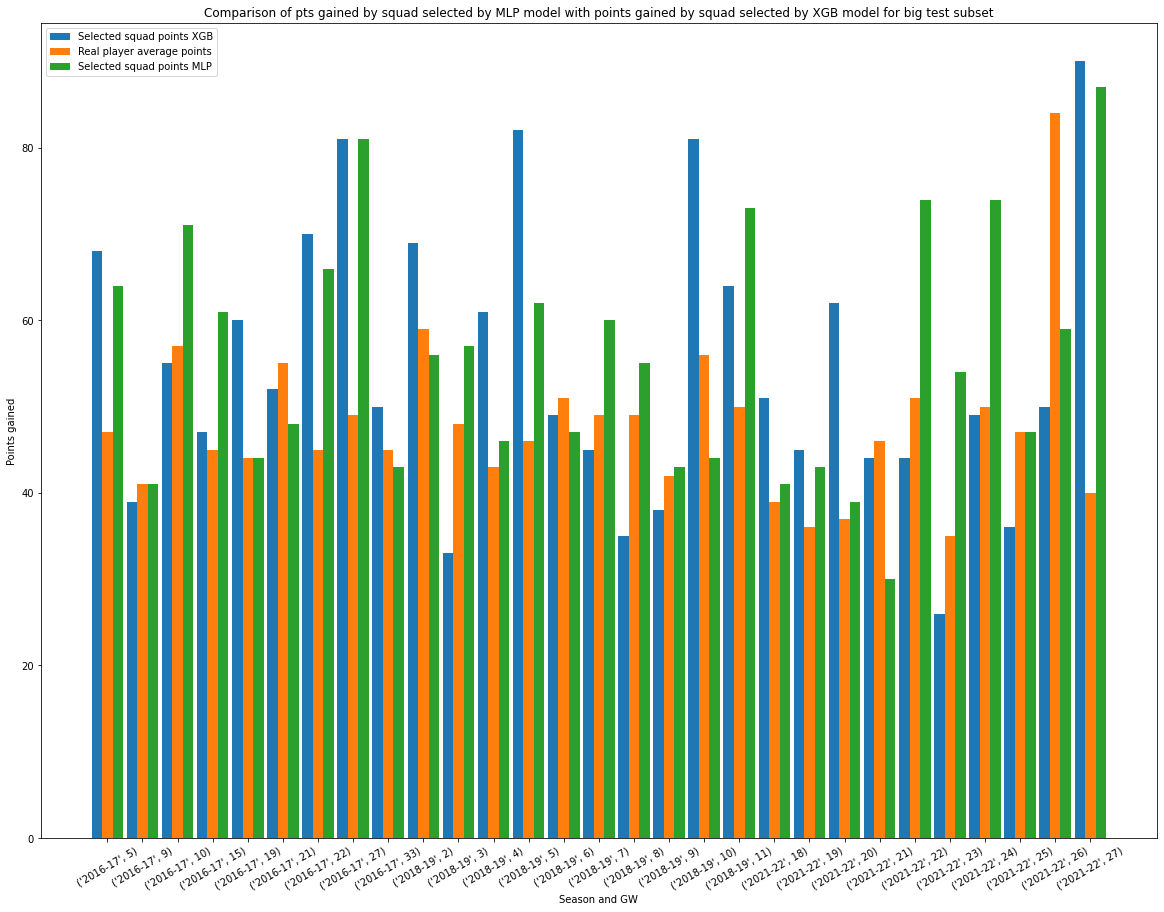

In [7]:
plt.figure(figsize=(20,15))

X_axis = np.arange(len(season_gameweeks_mlp))

plt.bar(X_axis - 0.3, selected_squad_points_xgb, 0.3, label = 'Selected squad points XGB')
plt.bar(X_axis, real_player_average_points_mlp, 0.3, label = 'Real player average points')
plt.bar(X_axis + 0.3, selected_squad_points_mlp, 0.3, label = 'Selected squad points MLP')

plt.xticks(X_axis, season_gameweeks_mlp, rotation=30)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
plt.legend()
plt.show()

#### MLP model sum of points

In [8]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp))
print('Sum of points gained by real players:', sum(real_player_average_points_mlp))
print('Difference:', sum(selected_squad_points_mlp) - sum(real_player_average_points_mlp), 'pts')

Sum of points gained by selected squad: 1610.0
Sum of points gained by real players: 1386
Difference: 224.0 pts


#### XGBoost model sum of points

In [9]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb))
print('Sum of points gained by real players:', sum(real_player_average_points_xgb))
print('Difference:', sum(selected_squad_points_xgb) - sum(real_player_average_points_xgb), 'pts')

Sum of points gained by selected squad: 1576.0
Sum of points gained by real players: 1386
Difference: 190.0 pts


## Conclusion #2
With models evaluated on much bigger test subset, we can see that results are still really promising. MLP model still looks better than XGBoost model, making bigger difference in points gained with bigger test subset. However, we need to remember that squads were picked without money/value constraints what is big simplification, cause fitting squad in actual budget constraints is key element of real FPL game. Actually evaluation script just takes best prospects for next gameweek, which usually means taking expensive superstar players.Also these are simple baseline models, trained on data containing information only about one last game player performance.

Next steps are to train models on data with more information about historical player performances (previous gameweeks/whole season) and to create more complex script to select best squad with consideration of constraints.

# Evaluate models trained on merged seasons data with historical rolling features

In [10]:
rolling_columns = ['assists', 'bonus', 'bps', 'clean_sheets',
                   'creativity', 'goals_conceded', 'goals_scored',
                   'ict_index', 'influence', 'minutes',
                   'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
                   'saves', 'selected', 'player_team_score', 'opponent_team_score', 'threat',
                   'total_points', 'transfers_in', 'transfers_out',
                   'value', 'yellow_cards']

times = ['all', 6, 3]

test_subset_XL = (['2016-17', [4, 8, 9, 14, 18, 20, 21, 26, 32]], ['2018-19', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], ['2021-22', [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [11]:
(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns, rolling_times=times)

In [12]:
# Train MLP and XGBoost models on specific subset
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=126, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model_mlp_rolling = train_mlp_model(model, x_train, y_train, verbose=0)

model_xgb_rolling = xgb.XGBRegressor()
model_xgb_rolling.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
# Make predictions on specific test subset using MLP and XGBoost models
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)
predictions_merged_mlp_rolling = merge_reversed_data_with_predictions(model_mlp_rolling, x_test, y_test, x_test_reversed)
predictions_merged_xgb_rolling = merge_reversed_data_with_predictions(model_xgb_rolling, x_test, y_test, x_test_reversed)

# Get squad and evaluate it for both models
results_mlp_rolling, selected_squad_points_mlp_rolling, real_player_average_points_mlp, season_gameweeks_mlp_rolling = evaluate_selected_squad_without_constraints(predictions_merged_mlp_rolling, test_subset_XL, 'mlp_model_rolling-no_constraints_test_subset_XL')
results_xgb_rolling, selected_squad_points_xgb_rolling, real_player_average_points_xgb, season_gameweeks_xgb_rolling = evaluate_selected_squad_without_constraints(predictions_merged_xgb_rolling, test_subset_XL, 'xgb_model_rolling-no_constraints_test_subset_XL')

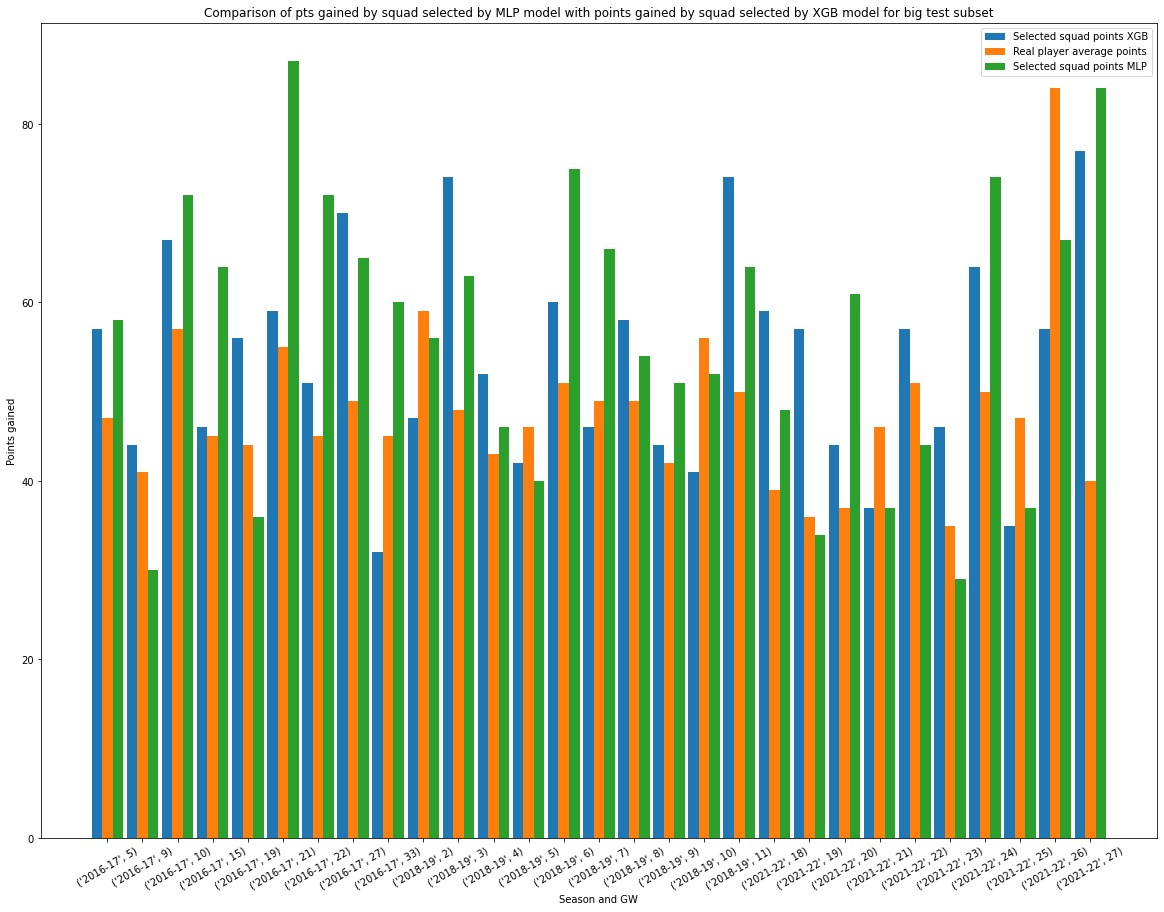

In [14]:
plt.figure(figsize=(20,15))

X_axis = np.arange(len(season_gameweeks_mlp_rolling))

plt.bar(X_axis - 0.3, selected_squad_points_xgb_rolling, 0.3, label = 'Selected squad points XGB')
plt.bar(X_axis, real_player_average_points_mlp, 0.3, label = 'Real player average points')
plt.bar(X_axis + 0.3, selected_squad_points_mlp_rolling, 0.3, label = 'Selected squad points MLP')

plt.xticks(X_axis, season_gameweeks_mlp_rolling, rotation=30)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
plt.legend()
plt.show()

#### MLP model sum of points

In [15]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp_rolling))
print('Sum of points gained by real players:', sum(real_player_average_points_mlp))
print('Difference:', sum(selected_squad_points_mlp_rolling) - sum(real_player_average_points_mlp), 'pts')

Sum of points gained by selected squad: 1626.0
Sum of points gained by real players: 1386
Difference: 240.0 pts


#### XGBoost model sum of points

In [16]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb_rolling))
print('Sum of points gained by real players:', sum(real_player_average_points_xgb))
print('Difference:', sum(selected_squad_points_xgb_rolling) - sum(real_player_average_points_xgb), 'pts')

Sum of points gained by selected squad: 1553.0
Sum of points gained by real players: 1386
Difference: 167.0 pts


## Conclusion #3
When adding rolling mean historical features to the data, it looks like there is no much difference in the results, even model with additional rolling features gives little worse results. I think that separating players by position and creating different datasets and models will be more effective. Another important change will be to add features with information of next match opponent team strength. Of course I also see a lot of possibilites of improvement in the model in the terms of hyperparameter selection like: rolling features time frames, adding dropout and many more typical hyperparameters of MLP and XGBoost models.

# Evaluate models trained on merged seasons data with historical rolling features and with data about next game opponent team

In [17]:
rolling_columns = ['assists', 'bonus', 'bps', 'clean_sheets',
                   'creativity', 'goals_conceded', 'goals_scored',
                   'ict_index', 'influence', 'minutes',
                   'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
                   'saves', 'selected', 'player_team_score', 'opponent_team_score', 'threat',
                   'total_points', 'transfers_in', 'transfers_out',
                   'value', 'yellow_cards']

times = ['all', 6, 3]

test_subset_XL = (['2016-17', [4, 8, 9, 14, 18, 20, 21, 26, 32]], ['2018-19', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]], ['2021-22', [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]])

In [18]:
(x_train, y_train), (x_test, y_test), (x_train_target, x_test_target), x_scaler = preprocess_seasons_data(random_split=False, test_subset=test_subset_XL, rolling_features=True, rolling_columns=rolling_columns, rolling_times=times, opponent_team_stats=True)

In [20]:
# Train MLP and XGBoost models on specific subset
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=126, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))
model_mlp_rolling_opponent_stats = train_mlp_model(model, x_train, y_train, verbose=0)

model_xgb_rolling_opponent_stats = xgb.XGBRegressor()
model_xgb_rolling_opponent_stats.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [21]:
# Make predictions on specific test subset using MLP and XGBoost models
x_test_reversed = reverse_processing(x_test, x_scaler, x_test_target)
predictions_merged_mlp_rolling_opponent_stats = merge_reversed_data_with_predictions(model_mlp_rolling_opponent_stats, x_test, y_test, x_test_reversed)
predictions_merged_xgb_rolling_opponent_stats = merge_reversed_data_with_predictions(model_xgb_rolling_opponent_stats, x_test, y_test, x_test_reversed)

# Get squad and evaluate it for both models
results_mlp_rolling_opponent_stats, selected_squad_points_mlp_rolling_opponent_stats, real_player_average_points_mlp, season_gameweeks_mlp_rolling_opponent_stats = evaluate_selected_squad_without_constraints(predictions_merged_mlp_rolling_opponent_stats, test_subset_XL, 'mlp_model_rolling_opponent_stats-no_constraints_test_subset_XL')
results_xgb_rolling_opponent_stats, selected_squad_points_xgb_rolling_opponent_stats, real_player_average_points_xgb, season_gameweeks_xgb_rolling_opponent_stats = evaluate_selected_squad_without_constraints(predictions_merged_xgb_rolling_opponent_stats, test_subset_XL, 'xgb_model_rolling_opponent_stats-no_constraints_test_subset_XL')

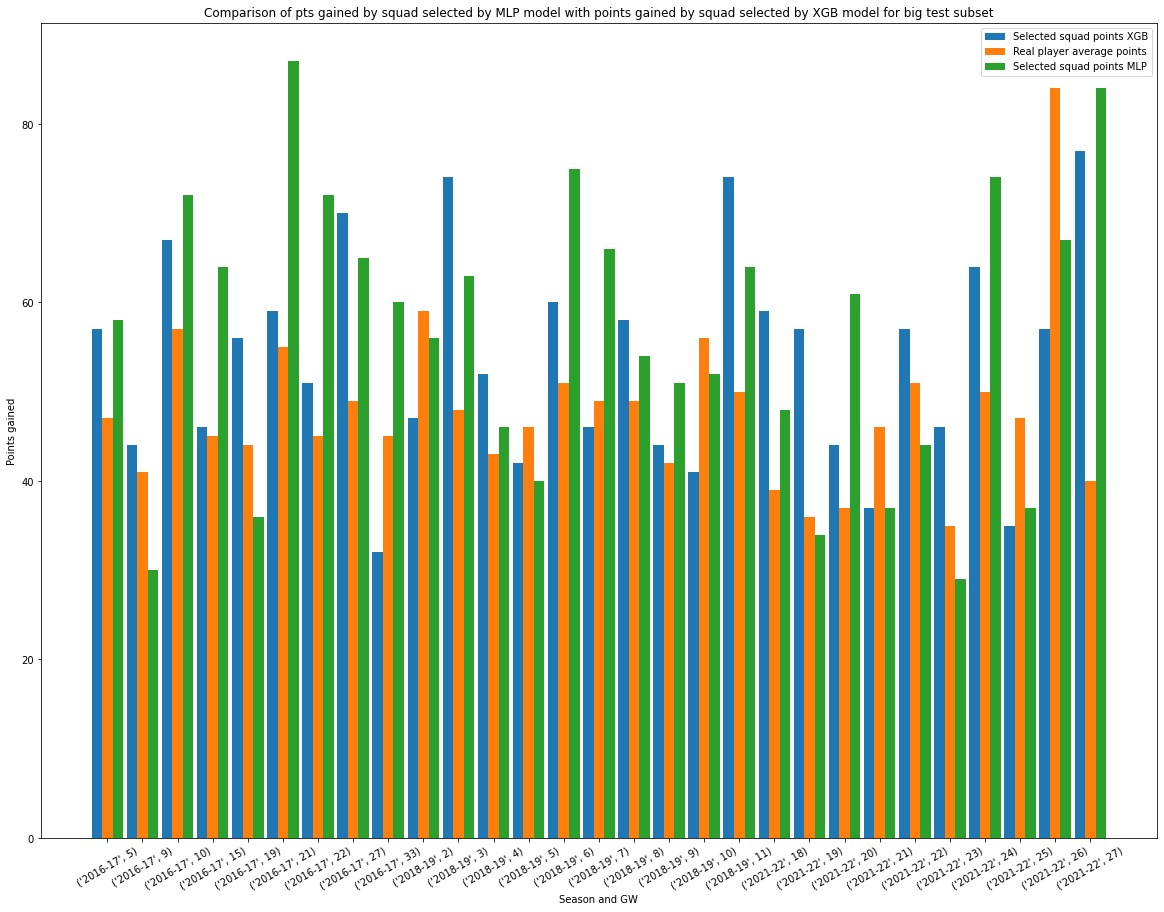

In [22]:
plt.figure(figsize=(20,15))

X_axis = np.arange(len(season_gameweeks_mlp_rolling))

plt.bar(X_axis - 0.3, selected_squad_points_xgb_rolling, 0.3, label = 'Selected squad points XGB')
plt.bar(X_axis, real_player_average_points_mlp, 0.3, label = 'Real player average points')
plt.bar(X_axis + 0.3, selected_squad_points_mlp_rolling, 0.3, label = 'Selected squad points MLP')

plt.xticks(X_axis, season_gameweeks_mlp_rolling, rotation=30)
plt.xlabel("Season and GW")
plt.ylabel("Points gained")
plt.title("Comparison of pts gained by squad selected by MLP model with points gained by squad selected by XGB model for big test subset")
plt.legend()
plt.show()

#### MLP model sum of points

In [23]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_mlp_rolling_opponent_stats))
print('Sum of points gained by real players:', sum(real_player_average_points_mlp))
print('Difference:', sum(selected_squad_points_mlp_rolling_opponent_stats) - sum(real_player_average_points_mlp), 'pts')

Sum of points gained by selected squad: 1770.0
Sum of points gained by real players: 1386
Difference: 384.0 pts


#### XGBoost model sum of points

In [24]:
print('Sum of points gained by selected squad:', sum(selected_squad_points_xgb_rolling_opponent_stats))
print('Sum of points gained by real players:', sum(real_player_average_points_xgb))
print('Difference:', sum(selected_squad_points_xgb_rolling_opponent_stats) - sum(real_player_average_points_xgb), 'pts')

Sum of points gained by selected squad: 1703.0
Sum of points gained by real players: 1386
Difference: 317.0 pts


## Conclusion #4
We can see that after adding stats of next gameweek opponent team to the training data, the model improves its performance significantly. Still, baseline MLP model gives us a better result than baseline XGBoost model. Difference of 384 points between MLP model trained with opponent team stats information and average FPL player is impressive. Anyway, we need to rememeber that squad is selected without money constraints. So after training data seems to be prepared pretty well, I will try to do some hyperparameter tuning and feature selection. Also, main idea is to create four different models, each one trained on different position (or two models, where one is for goalkeepers and second for players on the field).